## Generalized Additive Models

Note that you should open this and run it in Google Colab [<https://colab.research.google.com>]  

In [19]:
 #!pip install pygam

In [20]:
#!pip install ISLP

In [21]:
# import modules
import numpy as np
import pandas as pd
from scipy import stats

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)

A smoothing spline is a special case of a GAM with squared-error loss (least squares) and a single feature. To fit GAMs in Python we will use the _pygam_ package which can be installed via pip install pygam. The GAM is specified by associating each column of a model matrix with a particular smoothing operation: _s_ for smoothing spline; _l_ for linear, and _f_ for factor or categorical variables. The argument 0 passed to s below indicates that this smoother will apply to the first column of a feature matrix. Below, we pass it a matrix with a single column: X_age. The argument _lam_ is a penalty value for smoothing the splines.  Larger values of _lam_ force smoother splines.

We'll again work with the Wage data.

In [22]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

The `pygam` library generally expects a matrix of features so we reshape `age` to be a matrix (a two-dimensional array) instead
of a vector (i.e. a one-dimensional array). The `-1` in the call to the `reshape()` method tells `numpy` to impute the
size of that dimension based on the remaining entries of the shape tuple.

Let’s investigate how the fit changes with the smoothing parameter `lam`.
The function `np.logspace()` is similar to `np.linspace()` but spaces points
evenly on the log-scale. Below we vary `lam` from $10^{-2}$ to $10^6$.

In [23]:
X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

We now create a grid of values for age at which we want predictions.

In [24]:
# create a grid of points and put them in a DataFrame
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
age_df = pd.DataFrame({'age': age_grid})

We can fix the degrees of freedom of the smoothing
spline using a function included in the `ISLP.pygam` package. Below we
find a value of 'lam'=$\lambda$ that gives us roughly four degrees of
freedom. We note here that these degrees of freedom include the
unpenalized intercept and linear term of the smoothing spline, hence there are at least two
degrees of freedom.

In [25]:
# get the first term from 'gam'
age_term = gam.terms[0]
# get the approximately 'best' value for 'lam' based upon having the smallest squared error.
lam_4 = approx_lam(X_age, age_term, 4)
print(lam_4)
age_term.lam = lam_4
# print the approximate degrees of freedom corresponding to the value of 'lam' being 1446.7.
degrees_of_freedom(X_age, age_term)

[1446.68511262]


4.000000100003769

Let’s vary the degrees of freedom in a similar plot to above. We choose the degrees of freedom
as the desired degrees of freedom plus one to account for the fact that these smoothing
splines always have an intercept term. Hence, a value of one for `df` is just a linear fit.

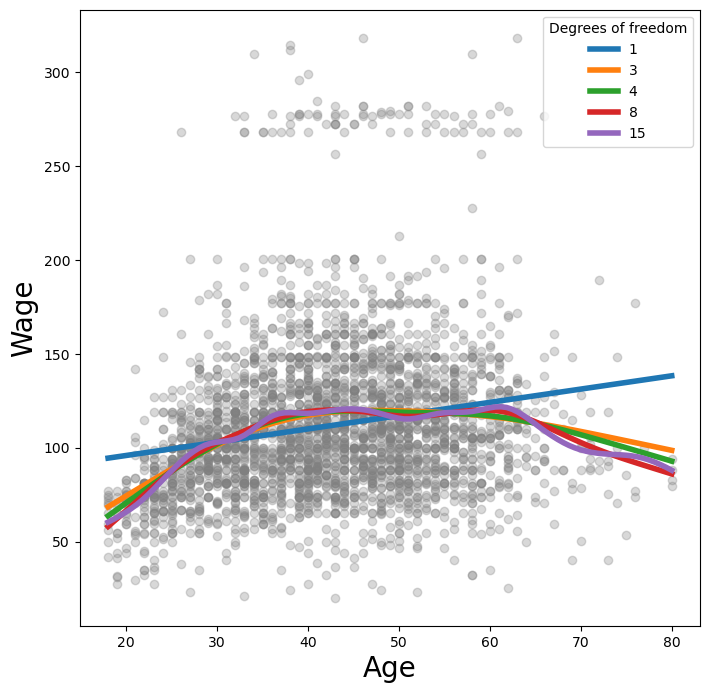

In [26]:

fig, ax = subplots(figsize=(8,8))
ax.scatter(X_age,
           y,
           facecolor='gray',
           alpha=0.3)
for df in [1,3,4,8,15]:
    lam = approx_lam(X_age, age_term, df+1)
    age_term.lam = lam
    gam.fit(X_age, y)
    ax.plot(age_grid,
            gam.predict(age_grid),
            label='{:d}'.format(df),
            linewidth=4)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20);
ax.legend(title='Degrees of freedom');

### Additive Models with Several Terms
The strength of generalized additive models lies in their ability to fit multivariate regression models with more flexibility than linear models. We demonstrate two approaches: the first in a more manual fashion using natural splines, and the second  using the `pygam` package and smoothing splines.

We now fit a GAM by hand to predict
`wage` using natural spline functions of `year` and `age`,
treating `education` as a qualitative predictor.
Since this is just a big linear regression model
using an appropriate choice of basis functions, we can simply do this
using the `sm.OLS()`  function.

We will build the model matrix in a more manual fashion here, since we wish
to access the pieces separately when constructing partial dependence plots.

In [27]:
# make natural spline with 4 df for predictor 'age'
ns_age = NaturalSpline(df=4).fit(age)
# make natural spline with 5 df for predictor 'year'
ns_year = NaturalSpline(df=5).fit(Wage['year'])
# combine and transform age and year as well as combine
# indicators for education level
Xs = [ns_age.transform(age),
      ns_year.transform(Wage['year']),
      pd.get_dummies(Wage['education']).values]
# horizontally stack the values from Xs into a matrix for regression
X_bh = np.hstack(Xs)
# fit the regression using the natural spline columns as predictors
# note that this is building a GAM by hand rather than
gam_bh = sm.OLS(y, X_bh).fit()

Here the function `NaturalSpline()` is the workhorse supporting
the `ns()` helper function.  We chose to use all columns of the
indicator matrix for the categorical variable `education`, making an intercept redundant.
Finally, we stacked the three component matrices horizontally to form the model matrix `X_bh`.

Natural splines are similar to basis splines that we used previously but they fit a linear equation beyond the minimum and the maximum the values for the predictor. 

Partial dependence plots are a way of looking at the relationship between
a feature and a target while holding the other predictors fixed at
their mean value.  

We now show how to construct partial dependence plots for each of the terms in our rudimentary GAM. We can do this by hand, given grids for `age` and `year`.   We simply predict with new $X$ matrices, fixing all but one of the features at a time.  The centering here is simply to have an understanding of the effect (differences from zero) of each predictor.

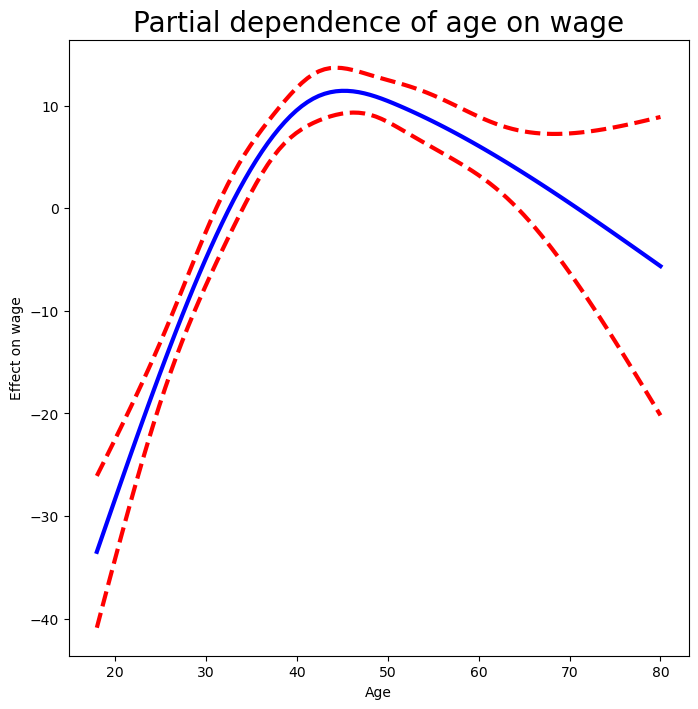

In [28]:
# create a grid of age values
# recall that the age_grid recreated above
age_grid = np.linspace(age.min(),
                       age.max(),
                       100)
# we are making a copy of the first 100 elements of X_bh
X_age_bh = X_bh.copy()[:100]
X_age_bh[:] = X_bh[:].mean(0)[None,:]
X_age_bh[:,:4] = ns_age.transform(age_grid)

# get the predicted values for
preds = gam_bh.get_prediction(X_age_bh)
# get confidence intervals for the predictions
bounds_age = preds.conf_int(alpha=0.05)
# get predicted values for each age
partial_age = preds.predicted_mean
# get mean of the predicted values
center = partial_age.mean()
# center partial_age and the confidence limits
partial_age -= center
bounds_age -= center
#
fig, ax = subplots(figsize=(8,8))
ax.plot(age_grid, partial_age, 'b', linewidth=3)
ax.plot(age_grid, bounds_age[:,0], 'r--', linewidth=3)
ax.plot(age_grid, bounds_age[:,1], 'r--', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20);

Let's explain in some detail what we did above. The idea is to create a new prediction matrix, where all but the columns belonging to `age` are constant (and set to  their training-data means). The four columns for `age` are filled in with the natural spline basis evaluated at the 100 values in `age_grid`.

* We made a grid of length 100 in `age`, and created a matrix `X_age_bh` with 100 rows and the same number of columns as `X_bh`.
* We replaced every row of this matrix with the column means of the original.
* We then replace just the first four columns representing `age` with the natural spline basis computed at the values in `age_grid`.

The remaining steps should by now be familiar.

We also look at the effect of `year` on `wage`; the process is the same.

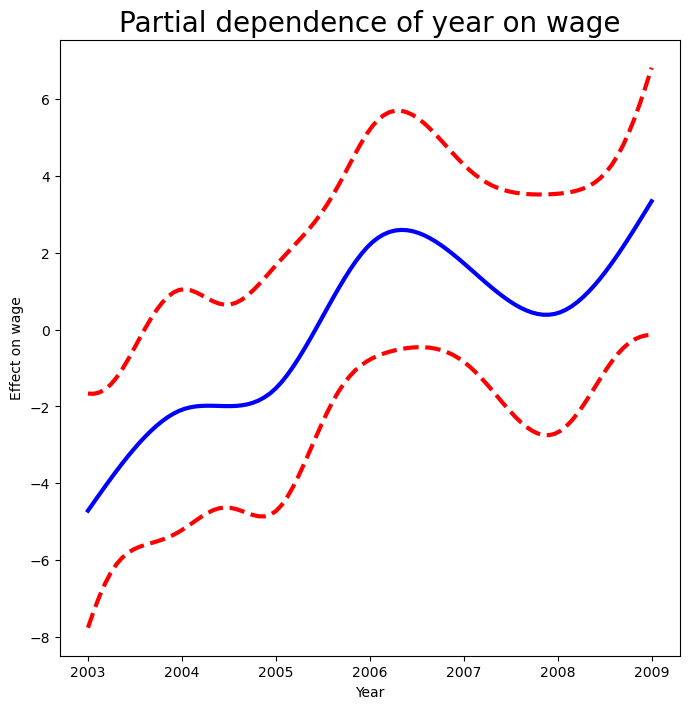

In [29]:
year_grid = np.linspace(2003, 2009, 100)
year_grid = np.linspace(Wage['year'].min(),
                        Wage['year'].max(),
                        100)
X_year_bh = X_bh.copy()[:100]
X_year_bh[:] = X_bh[:].mean(0)[None,:]
X_year_bh[:,4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha=0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center
fig, ax = subplots(figsize=(8,8))
ax.plot(year_grid, partial_year, 'b', linewidth=3)
ax.plot(year_grid, bounds_year[:,0], 'r--', linewidth=3)
ax.plot(year_grid, bounds_year[:,1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20);


We now fit the model using smoothing splines.  All of the
terms are fit simultaneously, taking each other into account to explain the response. The `pygam` package only works with matrices, so we must convert
the categorical series `education` to its array representation, which can be found
with the `cat.codes` attribute of `education`. As `year` only has 7 unique values, we
use only seven basis functions for it.

In [30]:
gam_full = LinearGAM(s_gam(0) +
                     s_gam(1, n_splines=7) +
                     f_gam(2, lam=0))
Xgam = np.column_stack([age,
                        Wage['year'],
                        Wage['education'].cat.codes])
gam_full = gam_full.fit(Xgam, y)

The two `s_gam()` terms result in smoothing spline fits, and use a default value for $\lambda$  (`lam=0.6`), which is an arbitrary choice from the 'pygam' library. For the categorical term `education`, specified using a `f_gam()` term,  we specify `lam=0` to avoid any shrinkage/smoothing.
We produce the partial dependence plot in `age` to see the effect of these choices.

The values for the plot
are generated by the `pygam` package. We provide a `plot_gam()`
function for partial-dependence plots in `ISLP.pygam`, which makes this job easier than in our last example with natural splines.

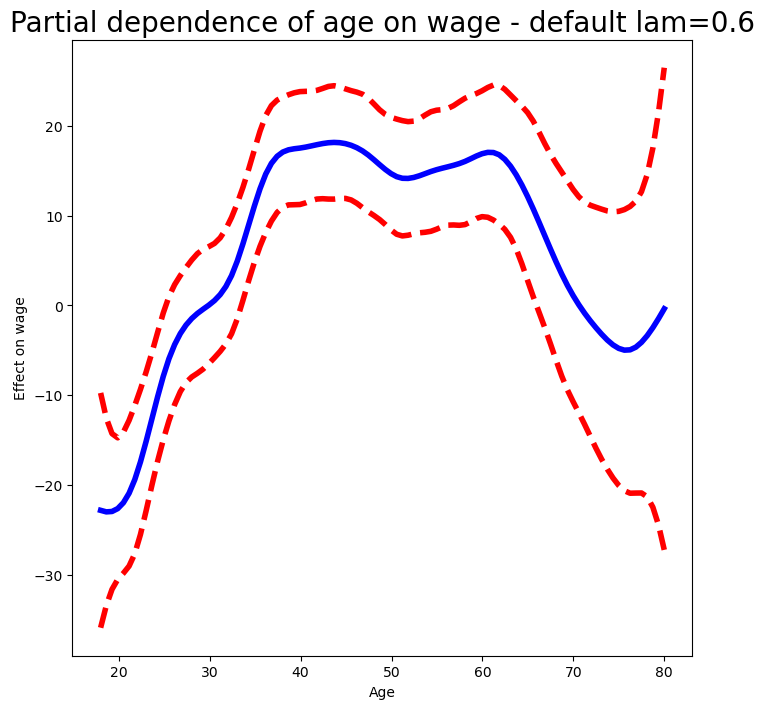

In [31]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=20);


We see that the function is somewhat wiggly. It is more natural to specify the `df` than a value for `lam`.
We refit a GAM using four degrees of freedom each for
`age` and  `year`. Recall that the addition of one below takes into account the intercept
of the smoothing spline.

In [32]:
# find best 'lam' values for smoothness
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)
gam_full = gam_full.fit(Xgam, y)

Note that updating `age_term.lam` above updates it in `gam_full.terms[0]` as well! Likewise for `year_term.lam`.

Repeating the plot for `age`, we see that it is much smoother.
We also produce the plot for `year`.

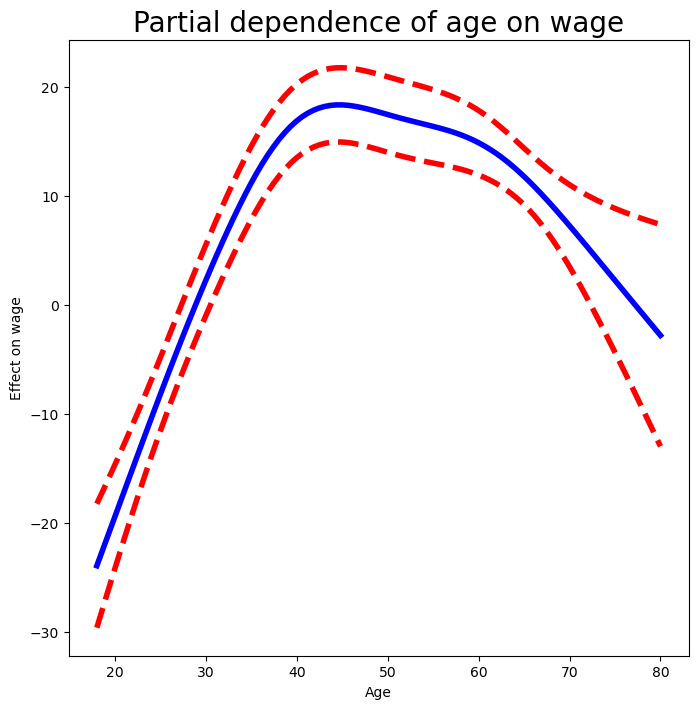

In [33]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20);


Text(0.5, 1.0, 'Partial dependence of year on wage')

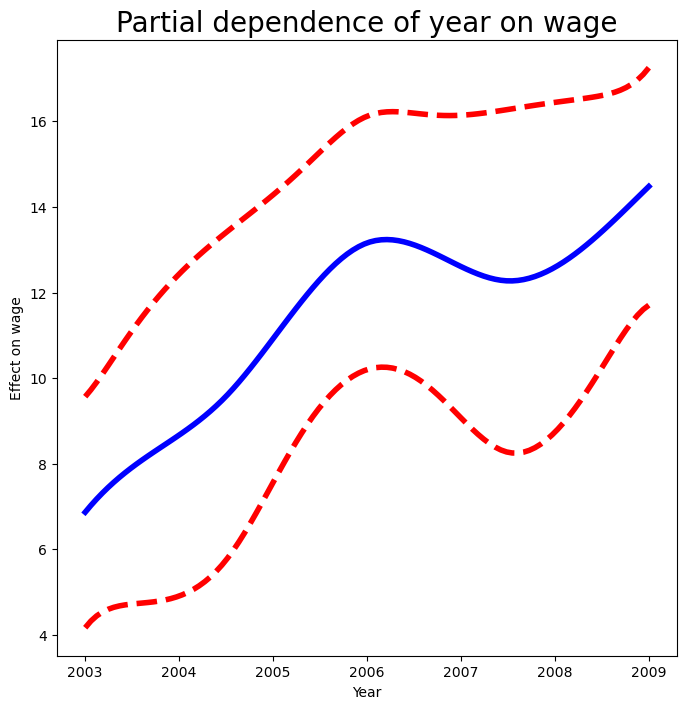

In [34]:
fig, ax = subplots(figsize=(8,8))
plot_gam(gam_full,
         1,
         ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)


Finally we plot `education`, which is categorical. The partial dependence plot is different, and more suitable for the set of fitted constants for each level of this variable.

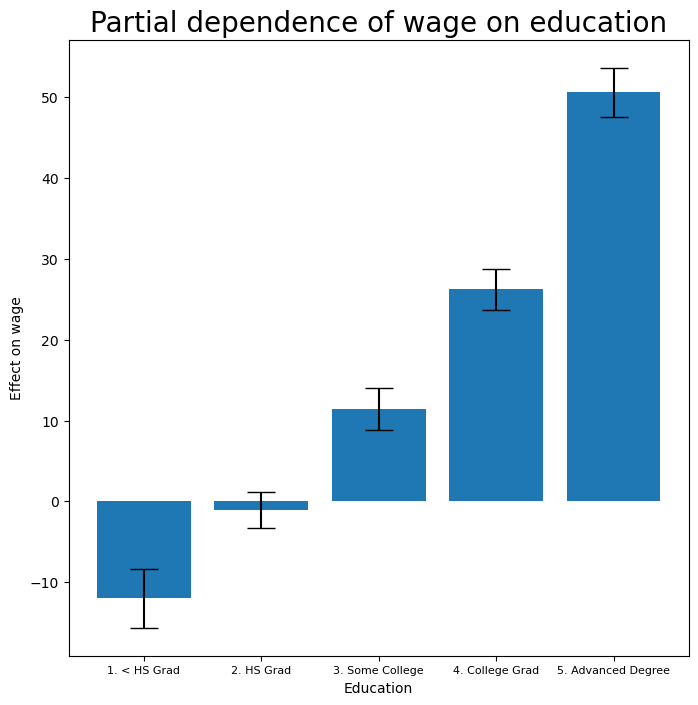

In [35]:
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 2)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education',
             fontsize=20);
ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8);


The code below gives us a summary for the GAM model similar to what we had
for our regression models.  We get p-values for our
predictors, 'P > x' and that is for a test of whether or not the
predictor improves the performance of the model.  There is also
an AIC value and something like an 'R-squared' value called 'Pseudo R-squared'.  

With the exception of AIC, the output here is estimated and should be
taken as 'estimates' rather than as hard values.  For example, if
you got a p-value of 0.042 from this output and you were using
a significance level of 0.05 you should be quite careful about
saying the former was clearly less than the latter.

Of course, you probably should be very careful using significance
levels anyway.  

In [36]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -24117.907
Number of Samples:                         3000 AIC:                                            48263.7995
                                                AICc:                                             48263.94
                                                GCV:                                             1246.1129
                                                Scale:                                           1236.4024
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

/tmp/ipykernel_9439/3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()
